<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/NN_predict_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traininig NN Spectrum

# Loading Necesary Libraries

In [1]:
# Importing necesary libraries
# Libraries for correct code execution 

import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import csv
import re
import array
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import os.path

from functools import reduce
from random import random, gauss
from math import modf, pi, cos, sin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import scipy.stats as st
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture
import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import os, time, math, csv, joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

# Load Enviroment

In [3]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [4]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

# Bootstrapping

In [ ]:
input_path = path + "/Spectrum/CNN/working_df.csv"

working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

In [ ]:
distances = [x*80 for x in range(1, 26)]

## Get max and min values of each column

In [ ]:
def get_max_min_val_col(working_df):
  data_working_df = working_df.iloc[:, 6:working_df.shape[1]]
  h_list = list(data_working_df.columns.values)
  max_min_col_dict = {header:[] for header in h_list}

  for d in tqdm(distances):
    boot_dist_df = working_df.loc[working_df['Distance_km'] == d]
    for idx in range(6, boot_dist_df.shape[1]):
      max_val_col = float(boot_dist_df.iloc[:, [idx]].max()) # max val in col
      min_val_col = float(boot_dist_df.iloc[:, [idx]].min()) # min val in col
      h = boot_dist_df.iloc[:, [idx]].columns # header of col
      h = h[0]
      max_min_col_dict[h].append((d, min_val_col, max_val_col))
  return max_min_col_dict

In [ ]:
max_min_col_dict = get_max_min_val_col(working_df)

In [ ]:
print(max_min_col_dict)

## Create new samples using bootstrap technique

In [ ]:
def create_bootstrap_samples(working_df, max_min_col_dict, num_of_new_samples, previos_amt_of_samples=13):
  import random

  row_data = []
  PBRS_id_data = []
  Distance_km_data = []
  power_dBm_data = []
  span_data = []

  h_list = list(working_df.columns.values)
  new_data = {header:[] for header in h_list}


  last_row_in_old_df_val = working_df.shape[0]
  for new_sample in tqdm(range(num_of_new_samples)): # generating (num_of_new_samples) new samples for en data
    for d in distances:
      new_data['row'].append(last_row_in_old_df_val)
      last_row_in_old_df_val += 1
      new_data['PBRS_id'].append(new_sample+(previos_amt_of_samples+1))
      new_data['Channels'].append(1)

      new_data['Distance_km'].append(d)
      new_data['power_dBm'].append(0)
      new_data['#span'].append(int(d/80))

      for k, v in max_min_col_dict.items(): # header:(d, min_val_col, max_val_col)
        for val in v:
          if val[0] == d:
            bootstrap_val = round(random.uniform(val[1], val[2]), 14)
            new_data[str(k)].append(bootstrap_val)
            break
  new_data_df = pd.DataFrame.from_dict(new_data)

  return new_data_df

In [ ]:
new_data_df = create_bootstrap_samples(working_df, max_min_col_dict, num_of_new_samples=87, previos_amt_of_samples=13)

## Combine previos df with bootstraped df

In [ ]:
new_working_df = working_df.append(new_data_df)

In [ ]:
new_working_df.to_csv(path+'/Spectrum/CNN/new_working_df.csv', index=False)

#New Train/Test Split

## Get Reference data

In [6]:
def get_reference_and_sample_data(working_df, num_reference, num_sample):
  reference_arr = [x for x in range(1, num_reference+1)]
  reference_data_df = working_df[working_df['PBRS_id'].isin(reference_arr)]

  sample_arr = [x for x in range(num_reference+1, num_sample+1)]
  sample_data_df = working_df[working_df['PBRS_id'].isin(sample_arr)]
  
  return reference_data_df, sample_data_df

## Get test/train split

In [7]:
def get_idx_train_test_split(working_df, trainingProp = 0.8):
  rows_training = np.array([])
  rows_testing = np.array([])
  distances = [x*80 for x in range(1, 26)]
  for d in distances:
    distance_working_df = working_df.loc[working_df['Distance_km'] == d]
    rows_mixed=np.random.permutation(distance_working_df.shape[0])

    training_amt = math.ceil(distance_working_df.shape[0]*trainingProp)
    testing_amt = distance_working_df.shape[0] - training_amt

    rows_training = np.append(rows_training, rows_mixed[:training_amt])
    rows_testing = np.append(rows_testing, rows_mixed[-testing_amt:])
  
  rows_training = rows_training.astype('int').tolist()
  rows_testing = rows_testing.astype('int').tolist()

  return rows_training, rows_testing

## Get frequencies filter

In [8]:
def frequencies_filter(df, num_selected_freq=20):
  info_df = df.iloc[:, 0:6]
  data_df = df.iloc[:, 6:df.shape[1]]
  span_val = int(data_df.shape[1]/num_selected_freq)
  for i in range(num_selected_freq):
    df2 = data_df.iloc[:, (i+1)*span_val].to_frame()
    if i+1 == 1:
      new_df = df2
    else:
      new_df = pd.merge(new_df, df2, left_index=True, right_index=True)
  new_df = info_df.join(new_df)
  
  return new_df

## Get features

In [9]:
#sample_freq_data_df
#distance_reference_df
#selected_rows = rows_training
def get_features(sample_freq_data_df, reference_freq_data_df, selected_rows):
  data_distance = []
  data_mean = []
  data_std = []
  data_pearson_min = []
  data_pearson_mean = []
  data_pearson_max = []
  data_CI_lower = []
  data_CI_upper = []

  for row_idx in tqdm(selected_rows):
    data_Y = sample_freq_data_df.iloc[row_idx,3] # distance of row selected
    data_X = np.array(sample_freq_data_df.iloc[row_idx,6:sample_freq_data_df.shape[1]]) #array of data in row selected
    data_distance.append(data_Y)
    data_std.append(np.std(data_X))
    data_mean.append(np.mean(data_X))

    data_ci = st.t.interval(alpha=0.90, df=len(data_X)-1, loc=np.mean(data_X), scale=st.sem(data_X))
    data_confidence_int_lower = data_ci[0]
    data_confidence_int_upper = data_ci[1]

    # Get reference data
    reference_freq_data_df
    distance_reference_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == data_Y]

    pearson_vals = []
    confidence_vals_upper = []
    confidence_vals_lower = []
    for reference_row in range(0, distance_reference_df.shape[0]):
      reference_X = np.array(distance_reference_df.iloc[reference_row,6:distance_reference_df.shape[1]])
      pearson_vals.append(round(pearsonr(data_X, reference_X)[0], 5))

      reference_ci = st.t.interval(alpha=0.90, df=len(reference_X)-1, loc=np.mean(reference_X), scale=st.sem(reference_X))
      reference_confidence_int_lower = reference_ci[0]
      confidence_vals_lower.append(reference_confidence_int_lower)
      reference_confidence_int_upper = reference_ci[1]
      confidence_vals_upper.append(reference_confidence_int_upper)

    data_pearson_min.append(np.min(pearson_vals))
    data_pearson_mean.append(np.mean(pearson_vals))    
    data_pearson_max.append(np.max(pearson_vals))

    data_CI_lower.append(abs(np.min(confidence_vals_lower)-data_confidence_int_lower))
    data_CI_upper.append(abs(np.max(confidence_vals_upper)-data_confidence_int_upper))
  data = {'distance':data_distance,
                  'mean':data_mean,
                  'std':data_std,
                  'pearson_min':data_pearson_min,
                  'pearson_mean':data_pearson_mean,
                  'pearson_max':data_pearson_max,
                  'delta_CI_min':data_CI_lower,
                  'delta_CI_max':data_CI_upper}

  data_df = pd.DataFrame(data)

  return data_df

## Main train/test split

In [10]:
def get_train_test_split_main(input_path, num_of_freq_selected, reference_amt):
  working_df = pd.read_csv(input_path)
  working_df['Distance_km'] = working_df['Distance_km'].astype(int)

  reference_data_df, sample_data_df = get_reference_and_sample_data(working_df, num_reference=reference_amt, num_sample=100)

  reference_freq_data_df = frequencies_filter(reference_data_df, num_selected_freq=num_of_freq_selected)
  sample_freq_data_df = frequencies_filter(sample_data_df, num_selected_freq=num_of_freq_selected)

  rows_training, rows_testing = get_idx_train_test_split(sample_data_df, trainingProp = 0.8)
  print('Calculating train split:')
  training_df = get_features(sample_freq_data_df, reference_freq_data_df, rows_training)
  print('Calculating test split:')
  testing_df = get_features(sample_freq_data_df, reference_freq_data_df, rows_testing)

  return training_df, testing_df

# Test amt of freq and references test

In [ ]:
num_of_freq_selected = 20
reference_amt = 30
input_path = path + "/Spectrum/NN/new_working_df.csv"

training_df, testing_df = get_train_test_split_main(input_path, num_of_freq_selected, reference_amt)

Calculating train split:


100%|██████████| 1400/1400 [00:35<00:00, 39.82it/s]


Calculating test split:


100%|██████████| 350/350 [00:08<00:00, 41.23it/s]


# Neural Network

In [ ]:
#training_df=pd.read_csv(path+'/Spectrum/NN/training_data_DNN.csv')

Y = training_df.iloc[:, 0].to_numpy().reshape(-1,1)
X = training_df.iloc[:, 1:training_df.shape[1]]

sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
Y_train = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
X_train = sc_input.fit_transform(X) # convert features to values from 0 to 1

#testing_df=pd.read_csv(path+'/Spectrum/NN/testing_data_DNN.csv')

Y = testing_df.iloc[:, 0].to_numpy().reshape(-1,1)
X = testing_df.iloc[:, 1:testing_df.shape[1]]


sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
Y_test = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
X_test = sc_input.fit_transform(X) # convert features to values from 0 to 1

## Training Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
    model = Sequential()
    model.add(Dense(76, input_dim = 7, activation = 'tanh'))
    model.add(Dense(38,activation='tanh'))
    model.add(Dense(19,activation='tanh'))
    model.add(Dense(1))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model

model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32, verbose=0)

start_time = time.time()
callback = [EarlyStopping(monitor='loss', patience=500)]#, TqdmCallback(verbose=2)]
model_ann.fit(X_train, Y_train, callbacks=callback)
time_train_ann = time.time() - start_time

In [ ]:
pickle.dump(model_ann,open(path+"/Spectrum/NN/NN_model.pkl","wb"))

if os.path.isfile(path+"/Spectrum/NN/NN_model.h5") is False:
  model_ann.model.save(path+"/Spectrum/NN/NN_model.h5")

INFO:tensorflow:Assets written to: ram://602ba244-a62d-46b4-90e4-35a00f331150/assets


INFO:tensorflow:Assets written to: ram://602ba244-a62d-46b4-90e4-35a00f331150/assets


In [ ]:
# Load network
from keras.models import load_model
mm = KerasRegressor(build_fn=ann, epochs=5000, batch_size=32, verbose=1)
mm.model = load_model(path+"/Spectrum/NN/NN_model.h5")

## Get predictions

,dist,pred,error
0,400,395.464417,0.011339
1,800,799.385010,0.000769
2,1200,1196.775879,0.002687
3,1520,1520.194580,0.000128
4,560,563.574036,0.006382
...,...,...,...
345,560,563.574036,0.006382
346,640,640.335999,0.000525
347,1440,1438.267456,0.001203
348,400,401.716766,0.004292


,dist,pred,error
0,400,395.464417,4.535583
1,800,799.385010,0.614990
2,1200,1196.775879,3.224121
3,1520,1520.194580,0.194580
4,560,563.574036,3.574036
...,...,...,...
345,560,563.574036,3.574036
346,640,640.335999,0.335999
347,1440,1438.267456,1.732544
348,400,401.716766,1.716766


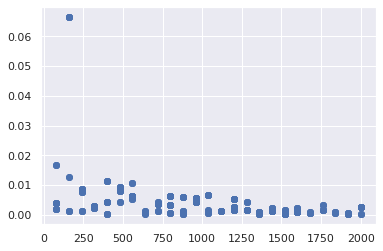

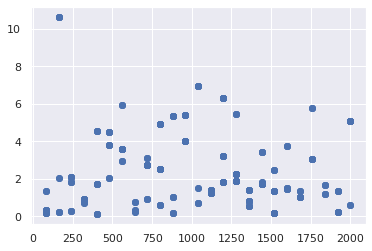

In [ ]:
# Predit
start_time = time.time()
Y_test_pred=model_ann.predict(X_test)
pred=list(Y_test_pred)

time_eval_ann=time.time()-start_time

dist_min=sc_output.data_min_[0] # 80
dist_max=sc_output.data_max_[0] # 2000

real=list(list(zip(*Y_test))[0])
real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
real_abs=[int(np.round(i)) for i in real_abs]
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))
res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
display(res)
res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
display(res_v2)
#res.to_csv(path+"/Spectrum/NN/results_pme_supervisedFeatures.csv", header=True, index=False)
plt.plot(real_abs,error,'bo')
plt.show()
plt.plot(real_abs,error_v2,'bo')
plt.show()

# Main

In [18]:
def main(input_path, num_of_freq_selected, reference_amt):

  training_df, testing_df = get_train_test_split_main(input_path, num_of_freq_selected, reference_amt)

  training_df.to_csv(path+"/Spectrum/NN/train_test_splits/training_data_NN_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)
  testing_df.to_csv(path+"/Spectrum/NN/train_test_splits/testing_data_NN_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)

  Y = training_df.iloc[:, 0].to_numpy().reshape(-1,1)
  X = training_df.iloc[:, 1:training_df.shape[1]]

  sc_input = MinMaxScaler()
  sc_output = MinMaxScaler()
  Y_train = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
  X_train = sc_input.fit_transform(X) # convert features to values from 0 to 1

  Y = testing_df.iloc[:, 0].to_numpy().reshape(-1,1)
  X = testing_df.iloc[:, 1:testing_df.shape[1]]


  sc_input = MinMaxScaler()
  sc_output = MinMaxScaler()
  Y_test = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
  X_test = sc_input.fit_transform(X) # convert features to values from 0 to 1

  print('Training model (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  def ann():
      model = Sequential()
      model.add(Dense(76, input_dim = 7, activation = 'tanh'))
      model.add(Dense(38,activation='tanh'))
      model.add(Dense(19,activation='tanh'))
      model.add(Dense(1))
      model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
      return model

  model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32, verbose=0)

  start_time = time.time()
  callback = [EarlyStopping(monitor='loss', patience=500)]#, TqdmCallback(verbose=2)]
  model_ann.fit(X_train, Y_train, callbacks=callback)
  time_train_ann = time.time() - start_time

  # Save model
  #pickle.dump(model_ann,open(path+"/Spectrum/NN/NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".pkl","wb"))

  if os.path.isfile(path+"/Spectrum/NN/NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5") is False:
    model_ann.model.save(path+"/Spectrum/NN/NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5")

  # Load network
  #from keras.models import load_model
  #mm = KerasRegressor(build_fn=ann, epochs=5000, batch_size=32, verbose=1)
  #mm.model = load_model(path+"/Spectrum/NN/NN_model.h5")

  print('Results (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')')
  # Predit
  start_time = time.time()
  Y_test_pred=model_ann.predict(X_test)
  pred=list(Y_test_pred)

  time_eval_ann=time.time()-start_time

  dist_min=sc_output.data_min_[0] # 80
  dist_max=sc_output.data_max_[0] # 2000

  real=list(list(zip(*Y_test))[0])
  real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
  real_abs=[int(np.round(i)) for i in real_abs]
  pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

  error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
  error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))

  res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
  res.to_csv(path+"/Spectrum/NN/NN_results_error/results_curve_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)

  res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
  res.to_csv(path+"/Spectrum/NN/NN_results_error/results_deltas_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)
  
  plt.plot(real_abs,error,'bo')
  plt.xlabel('Distances') 
  plt.ylabel('Error') 
  plt.title("Results Curve (freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+")")
  plt.savefig(path+"/Spectrum/NN/NN_results_plots/results_curve_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".png")
  plt.show()
  
  plt.plot(real_abs,error_v2,'bo')
  plt.xlabel('Distances') 
  plt.ylabel('Error') 
  plt.title("Results Curve (freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+")")
  plt.savefig(path+"/Spectrum/NN/NN_results_plots/results_deltas_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".png")
  plt.show()

  print('----------------------------------------------------------------------')

# TEST Freq and Reference size

Calculating train split:


100%|██████████| 1000/1000 [01:12<00:00, 13.78it/s]


Calculating test split:


100%|██████████| 250/250 [00:18<00:00, 13.65it/s]


Training model (freq_20_reference_50)...
Results (freq_20_reference_50)


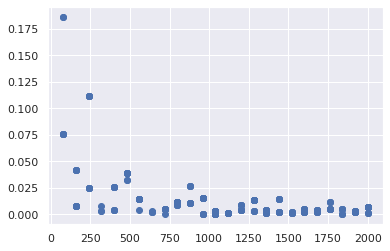

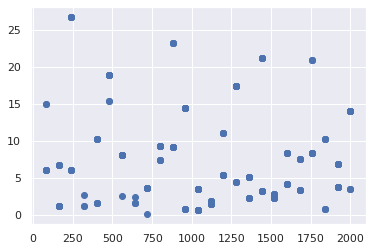

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1000/1000 [01:11<00:00, 13.93it/s]


Calculating test split:


100%|██████████| 250/250 [00:17<00:00, 13.92it/s]


Training model (freq_15_reference_50)...
Results (freq_15_reference_50)


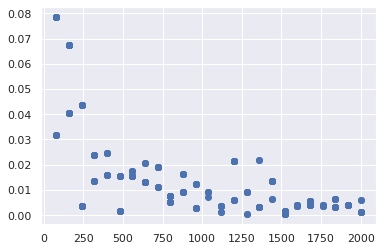

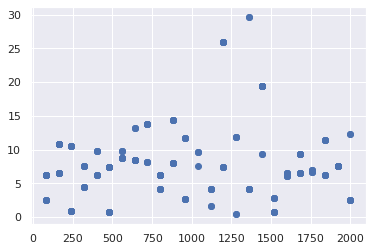

----------------------------------------------------------------------
Calculating train split:


 91%|█████████ | 908/1000 [01:05<00:06, 13.93it/s]


KeyboardInterrupt: ignored

In [17]:
#num_of_freq_selected = 20
#reference_amt = 30
input_path = path + "/Spectrum/NN/new_working_df.csv"

tests = {50:[20, 15, 10, 7, 5],
         30:[20, 15, 10, 7, 5],
         20:[20, 15, 10, 7, 5],
         10:[20, 15, 10, 7, 5]}

for k, v in tests.items():
  for val in v:
    num_of_freq_selected = val
    reference_amt = k
    main(input_path, num_of_freq_selected, reference_amt)